# Data Manipulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('data/train.csv', parse_dates=['first_day_of_month'])
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [16]:
# Removing row_id, county, and state because those are redundant columns
train.drop(['row_id', 'county', 'state'], axis=1, inplace=True)

In [17]:
train.head()

,cfips,first_day_of_month,microbusiness_density,active
0,1001,2019-08-01,3.007682,1249
1,1001,2019-09-01,2.884870,1198
2,1001,2019-10-01,3.055843,1269
3,1001,2019-11-01,2.993233,1243
4,1001,2019-12-01,2.993233,1243


In [22]:
# Separating day, month, and year into their own features
train['year'] = train['first_day_of_month'].dt.year
train['month'] = train['first_day_of_month'].dt.month
train['day'] = train['first_day_of_month'].dt.day
train.drop('first_day_of_month', axis=1, inplace=True)

In [25]:
train.head()

,cfips,microbusiness_density,active,year,month,day
0,1001,3.007682,1249,2019,8,1
1,1001,2.884870,1198,2019,9,1
2,1001,3.055843,1269,2019,10,1
3,1001,2.993233,1243,2019,11,1
4,1001,2.993233,1243,2019,12,1


In [27]:
np.unique(train['day'])

array([1], dtype=int64)

In [29]:
# Since the day column has only one value, we can remove that as well
train.drop('day', axis=1, inplace=True)

In [30]:
from sklearn.model_selection import train_test_split

X = train.drop(['microbusiness_density'], axis=1)
y = train['microbusiness_density']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Training

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [33]:
ln_reg = LinearRegression()
ln_reg.fit(X_train, y_train)


LinearRegression()

In [34]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

RandomForestRegressor()

In [35]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

# Initial Evaluation

$$SMAPE = \frac{1}{n} * \sum^{n}_{i=1}{\frac{2 * |P_i - A_i|}{(|A_i| + |P_i|)}}$$ 
where $P$ = predicted value and $A$ = actual value


In [55]:
def SMAPE(actual, pred):
  numerator = np.abs(pred - actual) * 2
  denominator = np.abs(actual) + np.abs(pred)
  return np.mean(numerator / denominator)

In [56]:
ln_preds = ln_reg.predict(X_val)
rf_preds = rf_reg.predict(X_val)
xg_preds = xg_reg.predict(X_val)

In [57]:
ln_smape = SMAPE(y_val, ln_preds)
rf_smape = SMAPE(y_val, rf_preds)
xg_smape = SMAPE(y_val, xg_preds)

In [61]:
print(f'Linear Regression: {ln_smape * 100:.2f}%')
print(f'Random Forest Regressor: {rf_smape * 100:.2f}%')
print(f'XGBoost Regressor: {xg_smape * 100:.2f}%')

Linear Regression: 56.08%
Random Forest Regressor: 1.66%
XGBoost Regressor: 19.53%


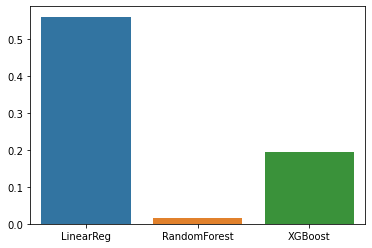

In [59]:
sns.barplot(x=['LinearReg', 'RandomForest', 'XGBoost'], y=[ln_smape, rf_smape, xg_smape]);

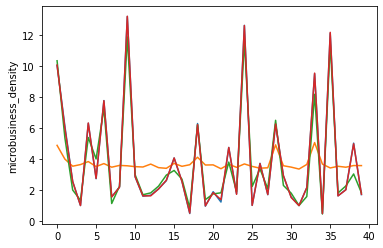

In [92]:
data_points = 40
sns.lineplot(x=np.arange(0, data_points), y=y_val[:data_points]) # Blue
sns.lineplot(x=np.arange(0, data_points), y=ln_preds[:data_points]) # Orange
sns.lineplot(x=np.arange(0, data_points), y=xg_preds[:data_points]) # Green
sns.lineplot(x=np.arange(0, data_points), y=rf_preds[:data_points]) # Red (on top of the blue)
plt.show()